# Comparison of levelsets for fgsm defense and l2 defense training

In [64]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
# seed = 56
# torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

180



## Data preparation

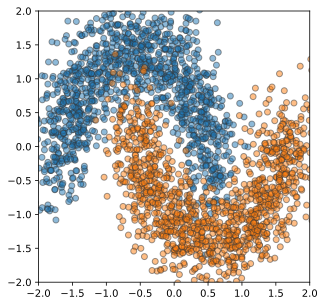

In [65]:
data_noise = 0.2
plotlim = [-2, 2]
subfolder = 'levelset_dbstyle'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, plotlim = plotlim, random_state = seed)


## Model dynamics

In [66]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 15, 15
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside


## Training and generating level sets

In [67]:

num_epochs = 120 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.3

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode_l1 = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode_l1 = torch.optim.Adam(rnode_l1.parameters(), lr=1e-3) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode_l2 = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode_l2 = torch.optim.Adam(rnode_l2.parameters(), lr=1e-3) 

In [68]:
from models.training import doublebackTrainer

trainer_rnode_l1 = doublebackTrainer(rnode_l1, optimizer_rnode_l1, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps, db_type = 'l1') 
trainer_rnode_l1.train(dataloader, num_epochs)


Iteration 0/38
Loss: 1.191
Robust Term Loss: 0.218
Accuracy: 0.578

Iteration 10/38
Loss: 1.270
Robust Term Loss: 0.189
Accuracy: 0.422

Iteration 20/38
Loss: 0.878
Robust Term Loss: 0.110
Accuracy: 0.547

Iteration 30/38
Loss: 0.971
Robust Term Loss: 0.101
Accuracy: 0.438
Epoch 1: 1.021

Iteration 0/38
Loss: 0.922
Robust Term Loss: 0.071
Accuracy: 0.406

Iteration 10/38
Loss: 0.568
Robust Term Loss: 0.032
Accuracy: 0.656

Iteration 20/38
Loss: 0.775
Robust Term Loss: 0.029
Accuracy: 0.438

Iteration 30/38
Loss: 0.654
Robust Term Loss: 0.022
Accuracy: 0.531
Epoch 2: 0.725

Iteration 0/38
Loss: 0.761
Robust Term Loss: 0.020
Accuracy: 0.406

Iteration 10/38
Loss: 0.601
Robust Term Loss: 0.018
Accuracy: 0.562

Iteration 20/38
Loss: 0.682
Robust Term Loss: 0.015
Accuracy: 0.453

Iteration 30/38
Loss: 0.680
Robust Term Loss: 0.020
Accuracy: 0.453
Epoch 3: 0.644

Iteration 0/38
Loss: 0.600
Robust Term Loss: 0.016
Accuracy: 0.531

Iteration 10/38
Loss: 0.575
Robust Term Loss: 0.013
Accuracy:

In [69]:
#We are training the last linear layer for the standard model and then use the same for the robust model for better comparison   
w = rnode_l1.linear_layer.weight
b = rnode_l1.linear_layer.bias

print(w)
print(b)

rnode_l2.linear_layer.weight = w
rnode_l2.linear_layer.bias = b

rnode_l2.linear_layer.requires_grad =  False

Parameter containing:
tensor([[ 0.7436, -0.1114],
        [-0.6869, -0.0214]], requires_grad=True)
Parameter containing:
tensor([-0.0898,  0.3060], requires_grad=True)


In [70]:
trainer_rnode_l2 = doublebackTrainer(rnode_l2, optimizer_rnode_l2, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps, db_type = 'l2') 
trainer_rnode_l2.train(dataloader, num_epochs)




Iteration 0/38
Loss: 0.917
Robust Term Loss: 0.031
Accuracy: 0.531

Iteration 10/38
Loss: 0.834
Robust Term Loss: 0.025
Accuracy: 0.516

Iteration 20/38
Loss: 0.657
Robust Term Loss: 0.011
Accuracy: 0.531

Iteration 30/38
Loss: 0.604
Robust Term Loss: 0.010
Accuracy: 0.562
Epoch 1: 0.750

Iteration 0/38
Loss: 0.636
Robust Term Loss: 0.009
Accuracy: 0.500

Iteration 10/38
Loss: 0.611
Robust Term Loss: 0.007
Accuracy: 0.500

Iteration 20/38
Loss: 0.498
Robust Term Loss: 0.004
Accuracy: 0.594

Iteration 30/38
Loss: 0.602
Robust Term Loss: 0.004
Accuracy: 0.438
Epoch 2: 0.583

Iteration 0/38
Loss: 0.489
Robust Term Loss: 0.004
Accuracy: 0.578

Iteration 10/38
Loss: 0.535
Robust Term Loss: 0.004
Accuracy: 0.484

Iteration 20/38
Loss: 0.509
Robust Term Loss: 0.005
Accuracy: 0.484

Iteration 30/38
Loss: 0.442
Robust Term Loss: 0.004
Accuracy: 0.562
Epoch 3: 0.508

Iteration 0/38
Loss: 0.488
Robust Term Loss: 0.006
Accuracy: 0.500

Iteration 10/38
Loss: 0.514
Robust Term Loss: 0.007
Accuracy:

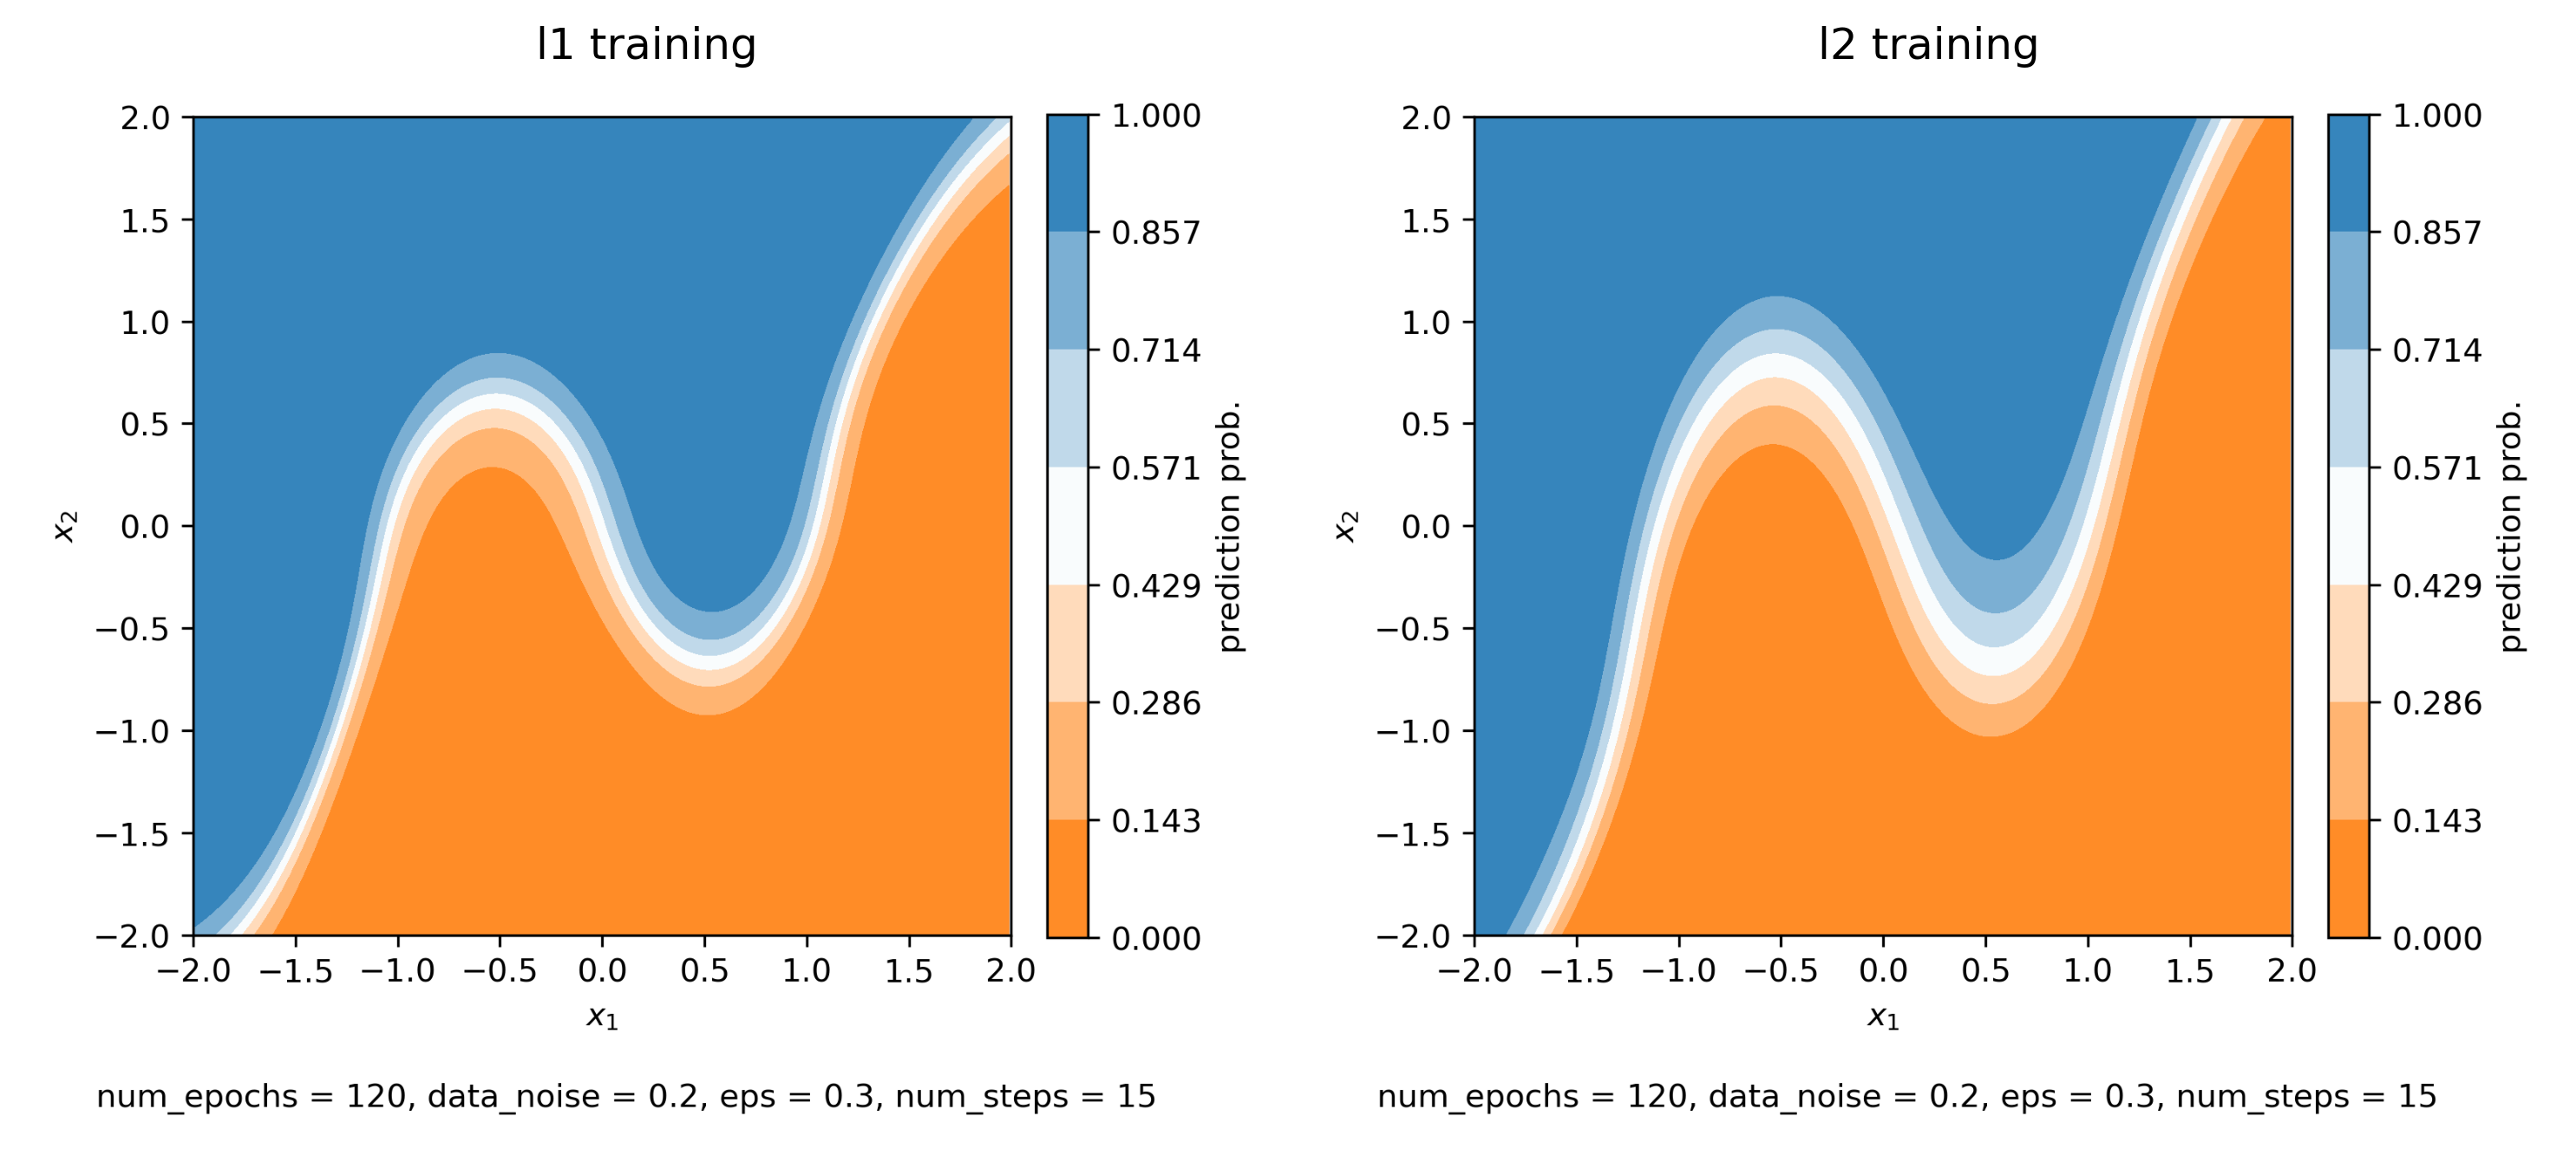

In [71]:
from plots.plots import classification_levelsets, comparison_plot
from IPython.display import Image
import os

if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
fig_name_base = os.path.join(subfolder, 'levelsets')
fig_name_l1 = fig_name_base + '_l1'
fig_name_l2 = fig_name_base + '_l2'
footnote = f'{num_epochs = }, {data_noise = }, {eps = }, {num_steps = }'
classification_levelsets(rnode_l1, fig_name_l1, footnote = footnote)
classification_levelsets(rnode_l2, fig_name_l2, footnote = footnote)

comparison_plot(fig_name_l1 + '.png', 'l1 training', fig_name_l2 + '.png', 'l2 training', fig_name_base + '_comp.png', figsize=(10,20), dpi = 300)
display(Image(fig_name_base + '_comp.png', width = 800))

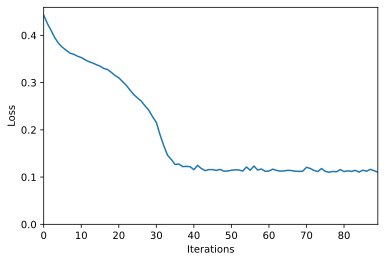

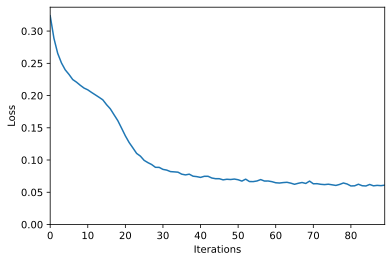

In [51]:
plt.plot(trainer_rnode_l1.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode_l1.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

plt.plot(trainer_rnode_l2.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode_l2.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [52]:
import imageio
import matplotlib.pyplot as plt

fig = plt.figure(dpi = 600, figsize = (10,30))

plt.subplot(131)
levelsets_rob = imageio.imread('trainingset.png')
plt.imshow(levelsets_rob)
plt.title('Training Data')
plt.axis('off')

plt.subplot(132)
levelsets = imageio.imread(fig_name_l1 + '.png')
plt.imshow(levelsets)
plt.title('l1 training')
plt.axis('off')

plt.subplot(133)
levelsets_rob = imageio.imread(fig_name_l2 + '.png')
plt.imshow(levelsets_rob)
plt.title('l2 training')
plt.axis('off')
plt.subplot_tool()

plt.savefig(fig_name_base + '_comp.png', bbox_inches='tight', dpi=600, format='png', facecolor = 'white')
plt.show()

NonGuiException: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.